In [13]:
import os
import json
import sympy
import requests

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json

In [14]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"

model1 = os.path.join(MODEL_PATH, "SEIRD_base_model01_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_base_model01_petrinet.json")
model3 = os.path.join(MODEL_PATH, "LV_sheep_foxes.json")

In [15]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1
num_samples = 100

In [16]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())
result1['data'][['timepoint_id', 'sample_id', 'S_state', 'I_state', 'R_state']].to_csv('sir.csv', index= False)


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_death_param,persistent_gamma_param,persistent_I0_param,S_state,I_state,E_state,R_state,D_state,infected_observable_state,dead_observable_state
0,0,0,0.0,0.44422,0.004347,0.41842,8.048838,19339992.0,8.048838,40.000000,0.000000,0.000000,8.048838,0.000000
1,1,0,1.0,0.44422,0.004347,0.41842,8.048838,19339990.0,12.911937,35.414085,4.475751,0.019541,12.911937,0.019541
2,2,0,2.0,0.44422,0.004347,0.41842,8.048838,19339984.0,15.465120,33.230457,10.442320,0.045591,15.465120,0.045591
3,3,0,3.0,0.44422,0.004347,0.41842,8.048838,19340012.0,16.846472,32.267570,17.201094,0.075100,16.846472,0.075100
4,4,0,4.0,0.44422,0.004347,0.41842,8.048838,19339968.0,17.633718,31.926027,24.397606,0.106520,17.633718,0.106520


### Plot histogram per state combination


In [17]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
from pyciemss.visuals import plots, vega
bin_outliers = False
log = False

# loading SIR data
sir_dataset = pd.read_csv("sir.csv")


def process_dataset(sir_dataset, bin_outliers, log):
    """
    This function bins the columns in the dataset that includes "_state" and plots histograms for each column.
    
    Inputs:
    sir_dataset (pd.DataFrame): The dataset with states, timepoint_id and sample_id
    bin_outliers (bool): A boolean value indicating whether to bin outliers separately in their own bin.
    log (bool): A boolean value indicating whether to use a log scale for the bins.
    
    Outputs:
    sir_dataset (pd.DataFrame): The processed dataset with added bin columns.
    bin_dict (dict): A dictionary storing the min and max values of each bin per column.
    """
    # Determine the number of bins using Sturges' rule and the nu
    num_bins =  math.ceil(math.log2(sir_dataset.shape[0]))

    sir_dataset_state = sir_dataset.loc[:, sir_dataset.columns.str.contains('_state')]

    # dictionary to store the min and max values of each bin per column
    bin_dict = {}

    sir_dataset_output = sir_dataset.copy()

    for col in sir_dataset_state.columns:
        max_val = sir_dataset_output[col].max()
        min_val = sir_dataset_output[col].min()

        # Calculate the 5th and 95th percentiles
        p5, p95 = sir_dataset_output[col].quantile([0.05, 0.95])

        # get histogram in the logspace
        if log:
            if bin_outliers:
                # put all outliers in their own bin at the end (trying to avoid the massive histogram bin for the S_state)
                p5_log = np.log10(p5)
                p95_log = np.log10(p95)

                bin_edges = np.logspace(np.max([0.0, p5_log]), p95_log, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else:
                min_log= np.log10(min_val)
                max_log = np.log10(max_val)
                bin_edges = np.logspace(np.max([0.0, min_log]), max_log, num=num_bins)
        else:
            if bin_outliers:
                bin_edges = np.linspace(p5, p95, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else: 
                bin_edges = np.linspace(min_val, max_val, num=num_bins)

        # saving bins edges in dictionary by state and bin number
        bin_dict[col] = [{i:(bin_edges[i], bin_edges[i+1])} for i in range(len(bin_edges)-1)]
        # add column with the bin number per histogram
        sir_dataset_output[col + '_bin'] = sir_dataset_output[col].apply(lambda x: np.digitize(x, bin_edges))

    # create a new column that combines the bin information for each state
    sir_dataset_output['combined_bin'] = sir_dataset_output.apply(lambda row: '_'.join([f'{col}_{row[col]}' for col in sir_dataset_output.columns if '_bin' in col]), axis=1)

    # create a mapping from original labels to shorter labels
    unique_bins = sir_dataset_output['combined_bin'].unique()
    label_mapping = {bin: f'bin_{i}' for i, bin in enumerate(unique_bins)}
    sir_dataset_output['short_bin'] = sir_dataset_output['combined_bin'].map(label_mapping)

    # save the mapping to a CSV file
    pd.DataFrame(list(label_mapping.items()), columns=['original_label', 'short_label']).to_csv('label_mapping.csv', index=False)

    return sir_dataset_output, bin_dict

def plot_paths(binned_data, *, n=None, fig_width=10):
    if n is None:
        n = len(sir_dataset_output['sample_id'].unique())

    G = nx.DiGraph()
    for sample_id in sir_dataset_output['sample_id'].unique()[:n]:
        sample_df = sir_dataset_output[sir_dataset_output['sample_id'] == sample_id]
        bins = sample_df['short_bin'].values
        for i in range(len(bins) - 1):
            if G.has_edge(bins[i], bins[i+1]):
                # we added this one before, just increase the weight by one
                G[bins[i]][bins[i+1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(bins[i], bins[i+1], weight=1)
    return G


sir_dataset_output, bin_dict= process_dataset(sir_dataset, bin_outliers = False, log = True)
G = plot_paths(sir_dataset_output)
schema = plots.spring_force_graph(graph = G)
# check bidirectional, add edge weights
plots.ipy_display(schema, format="interactive", dpi=72)

/var/folders/vn/q5vrjvfn60bfsnnd058cb6ww0000gn/T/ipykernel_27693/1124864400.py:55: RuntimeWarning: divide by zero encountered in log10
  min_log= np.log10(min_val)


In [18]:

def remove_consecutive_duplicates(lst):
    if not lst:  # if the list is empty, return it
        return lst
    new_lst = [lst[0]]  # add the first item of lst to new_lst
    for item in lst[1:]:  # iterate over the rest of lst
        if item != new_lst[-1]:  # if the current item is not the same as the last item in new_lst
            new_lst.append(item)  # add it to new_lst
    return new_lst

def plot_paths(binned_data, *, n=None, fig_width=10):
    if n is None:
        n = len(sir_dataset_output['sample_id'].unique())
    bins_list = []
    for sample_id in sir_dataset_output['sample_id'].unique()[:n]:
        sample_df = sir_dataset_output[sir_dataset_output['sample_id'] == sample_id]
        bins = sample_df['short_bin'].values
        bins_list.append(bins.tolist())

    return bins_list


sir_dataset_output, bin_dict= process_dataset(sir_dataset, bin_outliers = False, log = True)
bins_list =  plot_paths(sir_dataset_output)
bins_list

/var/folders/vn/q5vrjvfn60bfsnnd058cb6ww0000gn/T/ipykernel_27693/1124864400.py:55: RuntimeWarning: divide by zero encountered in log10
  min_log= np.log10(min_val)


[['bin_0',
  'bin_1',
  'bin_1',
  'bin_2',
  'bin_2',
  'bin_2',
  'bin_2',
  'bin_2',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_3',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_4',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_5',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',
  'bin_6',

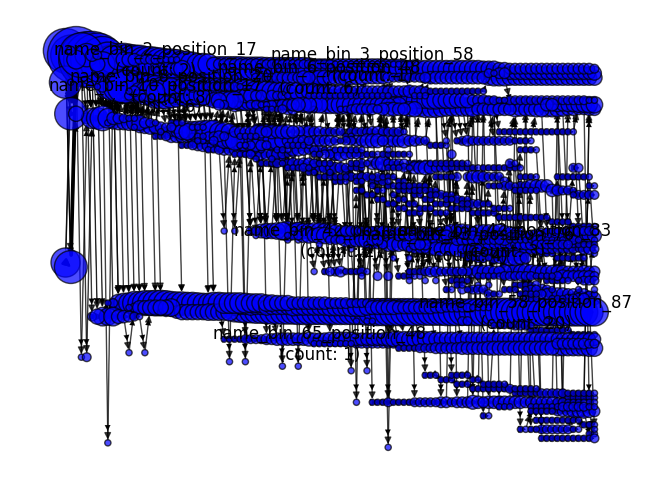

Node: name_bin_0_position_0, Attributes: {'count': 51}
Node: name_bin_1_position_1, Attributes: {'count': 42}
Node: name_bin_1_position_2, Attributes: {'count': 85}
Node: name_bin_2_position_3, Attributes: {'count': 47}
Node: name_bin_2_position_4, Attributes: {'count': 81}
Node: name_bin_2_position_5, Attributes: {'count': 83}
Node: name_bin_2_position_6, Attributes: {'count': 73}
Node: name_bin_2_position_7, Attributes: {'count': 56}
Node: name_bin_3_position_8, Attributes: {'count': 31}
Node: name_bin_3_position_9, Attributes: {'count': 40}
Node: name_bin_3_position_10, Attributes: {'count': 44}
Node: name_bin_3_position_11, Attributes: {'count': 45}
Node: name_bin_3_position_12, Attributes: {'count': 41}
Node: name_bin_3_position_13, Attributes: {'count': 38}
Node: name_bin_3_position_14, Attributes: {'count': 37}
Node: name_bin_3_position_15, Attributes: {'count': 32}
Node: name_bin_3_position_16, Attributes: {'count': 32}
Node: name_bin_3_position_17, Attributes: {'count': 29}
No

In [32]:

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store nodes and their counts
nodes = defaultdict(int)

# Create a dictionary to store edges and their weights
edges = defaultdict(int)

# Add nodes and edges to the graph
for sublist in bins_list:
    for i in range(len(sublist)):
        node = f"name_{sublist[i]}_position_{i}"
        nodes[node] += 1
        if i < len(sublist) - 1:
            next_node = f"name_{sublist[i + 1]}_position_{i + 1}"
            edges[(node, next_node)] += 1

# Add nodes with counts to the graph
for node, count in nodes.items():
    G.add_node(node, count=count)

# Add edges with weights to the graph
for edge, weight in edges.items():
    G.add_edge(*edge, weight=weight)

# Define positions for each node
pos = {node: (int(node.split('_')[4]), -int(node.split('_')[2])) for node in G.nodes()}

# Draw the graph with node size based on count
node_sizes = [data['count']*20 for _, data in G.nodes(data=True)]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color='b',  alpha=0.7, edgecolors='black')

# Randomly select 10 nodes and edges to label
random_nodes = random.sample(list(G.nodes(data=True)), 10)
random_edges = random.sample(list(G.edges(data=True)), 10)

# Add labels to the selected nodes and edges
node_labels = {node: f"{node}\n(count: {data['count']})" for node, data in random_nodes}
edge_labels = {edge: data['weight'] for edge, edge2, data in random_edges}
nx.draw_networkx_labels(G, pos, labels=node_labels)

# Draw edges with width based on weight
edge_widths = [data['weight']*.1 for _, _, data in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths)

plt.show()

# Print all nodes with their attributes
for node, data in G.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

# Print all edges with their attributes
for edge, edge2, data in G.edges(data=True):
    print(f"Edge: {edge}, Attributes: {data}")


The path with the most weight is: ['name_bin_0_position_0', 'name_bin_1_position_1', 'name_bin_1_position_2', 'name_bin_2_position_3', 'name_bin_2_position_4', 'name_bin_2_position_5', 'name_bin_2_position_6', 'name_bin_2_position_7', 'name_bin_3_position_8', 'name_bin_3_position_9', 'name_bin_3_position_10', 'name_bin_3_position_11', 'name_bin_3_position_12', 'name_bin_3_position_13', 'name_bin_3_position_14', 'name_bin_3_position_15', 'name_bin_3_position_16', 'name_bin_3_position_17', 'name_bin_3_position_18', 'name_bin_3_position_19', 'name_bin_3_position_20', 'name_bin_3_position_21', 'name_bin_3_position_22', 'name_bin_3_position_23', 'name_bin_3_position_24', 'name_bin_3_position_25', 'name_bin_3_position_26', 'name_bin_3_position_27', 'name_bin_4_position_28', 'name_bin_4_position_29', 'name_bin_4_position_30', 'name_bin_4_position_31', 'name_bin_4_position_32', 'name_bin_4_position_33', 'name_bin_4_position_34', 'name_bin_4_position_35', 'name_bin_4_position_36', 'name_bin_4_p

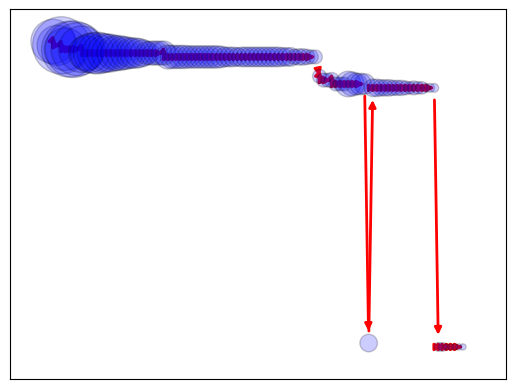

Node: name_bin_0_position_0, Attributes: {'count': 51}
Node: name_bin_1_position_1, Attributes: {'count': 42}
Node: name_bin_1_position_2, Attributes: {'count': 85}
Node: name_bin_2_position_3, Attributes: {'count': 47}
Node: name_bin_2_position_4, Attributes: {'count': 81}
Node: name_bin_2_position_5, Attributes: {'count': 83}
Node: name_bin_2_position_6, Attributes: {'count': 73}
Node: name_bin_2_position_7, Attributes: {'count': 56}
Node: name_bin_3_position_8, Attributes: {'count': 31}
Node: name_bin_3_position_9, Attributes: {'count': 40}
Node: name_bin_3_position_10, Attributes: {'count': 44}
Node: name_bin_3_position_11, Attributes: {'count': 45}
Node: name_bin_3_position_12, Attributes: {'count': 41}
Node: name_bin_3_position_13, Attributes: {'count': 38}
Node: name_bin_3_position_14, Attributes: {'count': 37}
Node: name_bin_3_position_15, Attributes: {'count': 32}
Node: name_bin_3_position_16, Attributes: {'count': 32}
Node: name_bin_3_position_17, Attributes: {'count': 29}
No

In [35]:

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Create a directed graph
G = nx.DiGraph()

# Create a dictionary to store nodes and their counts
nodes = defaultdict(int)

# Create a dictionary to store edges and their weights
edges = defaultdict(int)

# Add nodes and edges to the graph
for sublist in bins_list:
    for i in range(len(sublist)):
        node = f"name_{sublist[i]}_position_{i}"
        nodes[node] += 1
        if i < len(sublist) - 1:
            next_node = f"name_{sublist[i + 1]}_position_{i + 1}"
            edges[(node, next_node)] += 1

# Add nodes with counts to the graph
for node, count in nodes.items():
    G.add_node(node, count=count)

# Add edges with weights to the graph
for edge, weight in edges.items():
    G.add_edge(*edge, weight=weight)

# Find the maximum weight in the graph
max_weight = max(data['weight'] for _, _, data in G.edges(data=True))

# Modify the weights in the graph so that Dijkstra's algorithm finds the path with the most weight
for edge, edge2, data in G.edges(data=True):
    data['weight'] = max_weight - data['weight'] + 1

# Use Dijkstra's algorithm to find the path with the most weight
source = list(G.nodes)[0]  # use the first node as source
target = list(G.nodes)[-1]  # use the last node as target
path = nx.dijkstra_path(G, source, target, weight='weight')

print(f"The path with the most weight is: {path}")

# Define positions for each node
pos = {node: (int(node.split('_')[4]), -int(node.split('_')[2])) for node in G.nodes()}

# Draw the path with the most weight
path_edges = list(zip(path, path[1:]))
node_sizes = [data['count']*20 for node, data in G.nodes(data=True) if node in path]
nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='b', node_size=node_sizes, alpha=0.2, edgecolors='black')
nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

# Add labels for all nodes and edges
node_labels = {node: node for node in G.nodes()}
edge_labels = {(u, v): data['weight'] for u, v, data in G.edges(data=True)}
# Add labels for nodes in the path
node_labels = {node: node for node in path[:5]}
#nx.draw_networkx_labels(G, pos, labels=node_labels)

plt.show()

# Print all nodes with their attributes
for node, data in G.nodes(data=True):
    print(f"Node: {node}, Attributes: {data}")

# Print all edges with their attributes
for edge, edge2, data in G.edges(data=True):
    print(f"Edge: {edge}, Attributes: {data}")


